<a href="https://colab.research.google.com/github/Thewhey-Brian/qbio577_fall2022/blob/main/2022-seq-to-profile-cnn-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Data from a mysterious celltype

Your collaborators performed ChIP-seq for two different factors in a mysterious new cell type.

They send you a file with DNA sequences and the matched profiles for a set of regions.

They believe there is an interaction between the two factors, but would like your help modeling and analyzing the data. 

Try to answer their questions concisely.


In [104]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import random
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import io
import h5py
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K



In [106]:
def download_h5(dataset_url, filename = 'dataset.h5'):
  with requests.Session() as session:
      r = session.get(dataset_url, stream=True)
      r.raise_for_status()
      with open(filename, 'wb') as hd5:
          for chunk in r.iter_content(chunk_size=io.DEFAULT_BUFFER_SIZE):
              hd5.write(chunk)

In [107]:
DATA_URL = 'https://raw.githubusercontent.com/Fudenberg-Research-Group/2022_seq-to-profile/main/dataset1.h5'

download_h5(DATA_URL, filename = 'dataset1.h5')

In [108]:
### reading in the h5 data 
with  h5py.File('dataset1.h5', 'r') as h:
    sequences = h['seqs'].asstr()[()]
    targets = h['targets'][()]

Text(0.5, 0, 'position, bp')

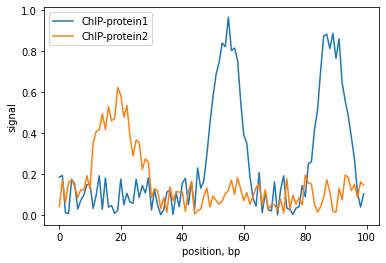

In [109]:
## To take a quick look at one of their profiles
plt.plot( targets[0,:,0], label='ChIP-protein1');

plt.plot( targets[0,:,1], label='ChIP-protein2');
plt.legend()
plt.ylabel("signal")
plt.xlabel("position, bp")

## 1.0 Try to fit the data with a seq-to-profile neural network. 
- Follow similar steps to those taken in the [Zou et al primer](https://colab.research.google.com/drive/17E4h5aAOioh5DiTo7MZg4hpL6Z_0FyWr#scrollTo=qSOUwoG_vHRA), e.g.: 
  - one-hot encode the DNA, 
  - set aside a test set, 
  - define a convolutional architecture, perhaps with additional or modified layers
  - consider what sort of loss function and activation to use. 
- Use [EarlyStopping](https://keras.io/api/callbacks/early_stopping/)
- Report your test set accuracy. Report an interpretable metric as well. 
- Where does the model do well or struggle? 


Note: if the validation loss is not decreasing during training, the specified model may not be well-matched for the problem at hand. Consider how to modify the model (e.g. a model with sigmoid activation at the final layer would never be able to learn negative values).

In [110]:
len(sequences)

5000

In [111]:
sequences

array(['CGATGTGTCCTCAAGTACCATCGGCGCCTTGACCTCCCCCCTGCCACACCTGGGGCGGGCACGAGATGTTTACCGTCAAAACGGCGGGGAGGGAGTGGGT',
       'TTTGCAGGGTTTGTCTGGGCAGTAGTGGTAGTTTCAGTGCCTCTCTACCCTCCCCCATCTAAATAGACTCTGATGACAGTAGGCTGAACTCGAAAGATAT',
       'CTGGGAGGGCCGAACCTGGTTGCAGGGATCCCCTCCCCTTCTAACCATCACACTCTCTCGGGGCAAGAGACGCGTCCCTCCCTTATCCCCTCCCCCGGCT',
       ...,
       'GGCCAAGCGGGTCCCCACCCCATTGGCAAGTTCGACTTTCGTGTCACGGTCTTGTTGGACGGATGGAGGTGCCTGATGTCTTGTGCTCGCCCCGTTACCG',
       'TAATTACTGACAAACAATCAATCACCGATGTAGTAAGCCTTGACGGCCCTCCCCTGACACTTAGGGGCGGGTGTTCTCCGCCCTCCCCTACCCTCCCCAC',
       'CGAAGCCATAGGGATGGCATGACACTCGCCCCCACTGTCCCCTCCCTATCATCTGAGGGGAGAGCACTCGTAGGGAGAGTCCAGGGTGTTATTGTAAGAC'],
      dtype=object)

In [112]:
# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CGATGTGTCC ... GGGAGTGGGT
One hot encoding of Sequence #1:
 [[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [113]:
targets

array([[[0.18693397, 0.04285306],
        [0.19509646, 0.17233472],
        [0.01371456, 0.06440441],
        ...,
        [0.11131296, 0.08826273],
        [0.04060131, 0.1638418 ],
        [0.10595823, 0.14774395]],

       [[0.00731803, 0.19034147],
        [0.19768315, 0.01729043],
        [0.03495773, 0.13858244],
        ...,
        [0.06991564, 0.03575747],
        [0.19402792, 0.01899964],
        [0.12425554, 0.03564619]],

       [[0.8409291 , 0.03339849],
        [0.77489094, 0.12247718],
        [0.84373463, 0.13402167],
        ...,
        [0.29823266, 0.13811015],
        [0.32180015, 0.00746408],
        [0.17854939, 0.17040232]],

       ...,

       [[0.15042477, 0.17073063],
        [0.03019776, 0.05743501],
        [0.17464405, 0.18799943],
        ...,
        [0.19679073, 0.01991717],
        [0.15840526, 0.04667264],
        [0.1022204 , 0.04779275]],

       [[0.08642412, 0.11934765],
        [0.18346027, 0.08687415],
        [0.04566572, 0.0697746 ],
        .

In [114]:
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, targets, test_size=0.25, random_state=42)

In [115]:
train_features.shape

(3750, 100, 4)

In [116]:
train_labels.shape

(3750, 100, 2)

In [117]:
from keras import backend as K
def pearson_r(y_true, y_pred):
    # use smoothing for not resulting in NaN values
    # pearson correlation coefficient
    # https://github.com/WenYanger/Keras_Metrics
    epsilon = 10e-5
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / (r_den + epsilon)
    return K.mean(r)

In [118]:
#3-4 layers needed
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, strides=1, 
                 input_shape=(train_features.shape[1], 4), padding='same'))
model.add(MaxPooling1D(pool_size=12,strides=1, padding="same"))
model.add(Dense(300, activation='relu', input_shape=(100,32)))
model.add(Dense(2))
model.compile(loss='mse', optimizer="adam", metrics=["accuracy","mse",pearson_r])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 100, 32)           1568      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 dense_6 (Dense)             (None, 100, 300)          9900      
                                                                 
 dense_7 (Dense)             (None, 100, 2)            602       
                                                                 
Total params: 12,070
Trainable params: 12,070
Non-trainable params: 0
_________________________________________________________________


In [119]:
train_labels[0].shape

(100, 2)

In [120]:
random.seed(123)
callback = EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_features, train_labels, epochs=100, verbose=0, validation_split=0.25, callbacks=[callback])

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


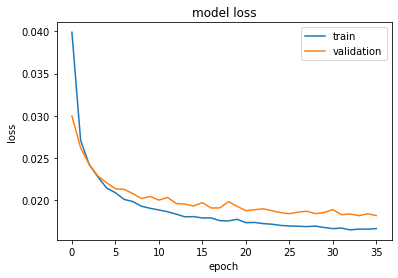

In [121]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [122]:
preds=model.predict(test_features)

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [123]:
def plot_fitting_result(seq_num_list, preds, test_labels):
  # seq_num_list: a list of sequencing number to plot
  # preds: prediction results
  # test_labels: ture values for the test set
  n = len(seq_num_list)
  i = 0
  fig, ax = plt.subplots(n, 2, figsize=(16,20))
  cols = ['Model Fitting Results For Protein 1', 'Model Fitting Results For Protein 2']
  for seq_num in seq_num_list: 

    ax[i, 0].plot(preds[seq_num,:,0])
    ax[i, 0].plot(test_labels[seq_num,:,0])
    
    ax[i, 1].plot(preds[seq_num,:,1])
    ax[i, 1].plot(test_labels[seq_num,:,1])
    ax[i, 1].legend(['predicted', 'true'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    i += 1
  
  for x, col in zip(ax[0], cols):
    x.set_title(col)
  for x in ax.flat:
    x.set(xlabel='Nucleotide population', ylabel='Profile value')
  for x in ax.flat:
    x.label_outer()

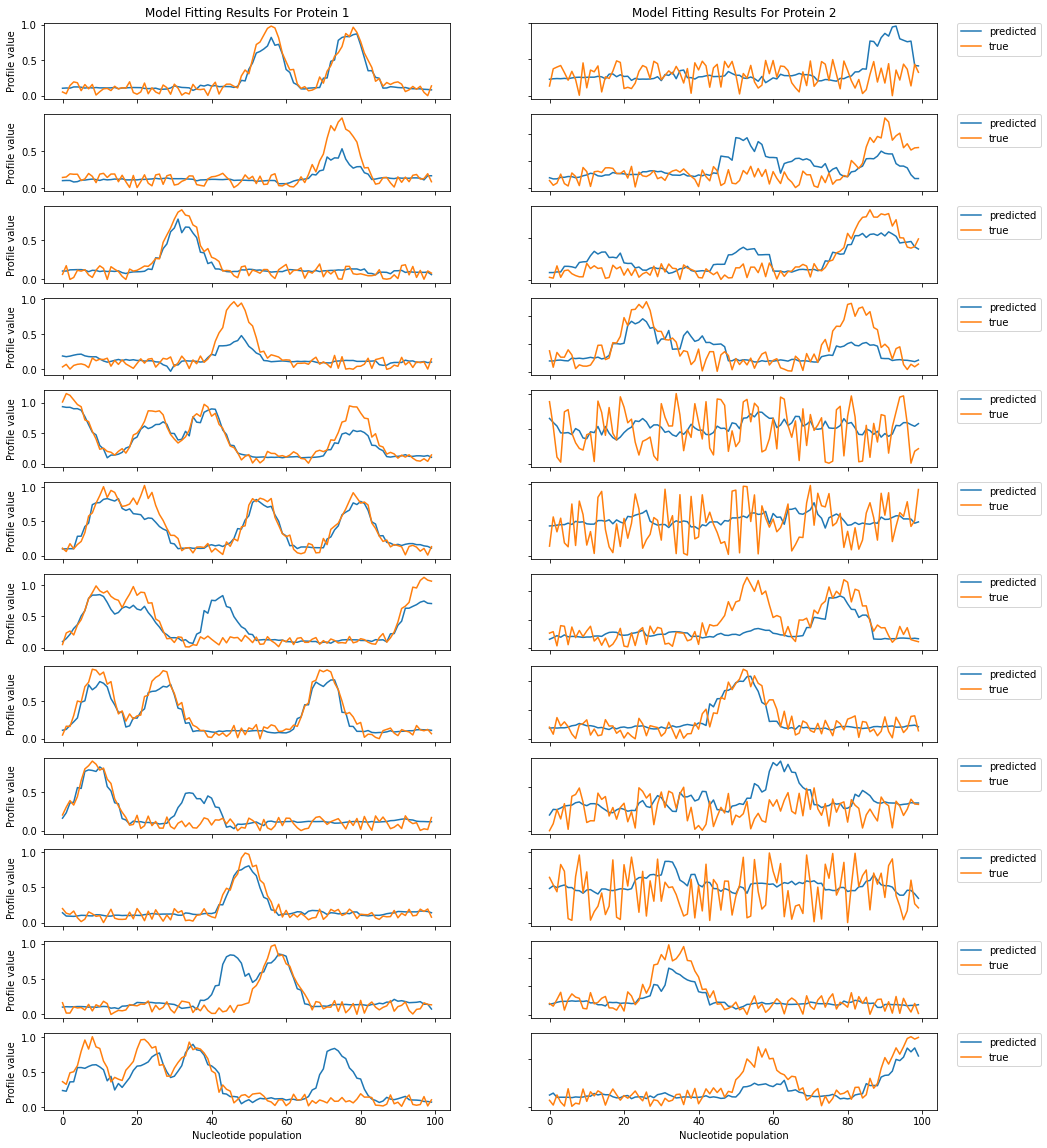

In [124]:
random.seed(123)
plot_fitting_result(random.sample(range(0, 1249), 12), preds, test_labels)

In [125]:
model.evaluate(test_features, test_labels)

[0.018125013141334058, 0.69564, 0.018125014, 0.808561]

The test set accuracy is about 70%. The MSE of this model in the test set is about 0.018, and the person correlation is around 0.81. Also, from the plots above, the designed model can more accurately predict the profile for factor 1 and less accurately for factor 2. This might be because the data for factor 2 is quite noisy. But overall, this model can capture most of the peaks of these profile data.

## 1.1 Can you determine any rule(s) that influence the profiles for the two factors?
Try saliency mapping as employed in the primer. Are there motifs, or an interplay between motifs, that boost or dampen the profiles? 
positive interactions, negative interactions, etc. binding  in one thing causes boosted binding in another 

In [126]:
def compute_salient_bases(model, x, protein):
  total=0
  for i in range(99):
    total=total+model.output[0][i][protein]
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(total, model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  x_value = np.expand_dims(x, axis=0)
  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal

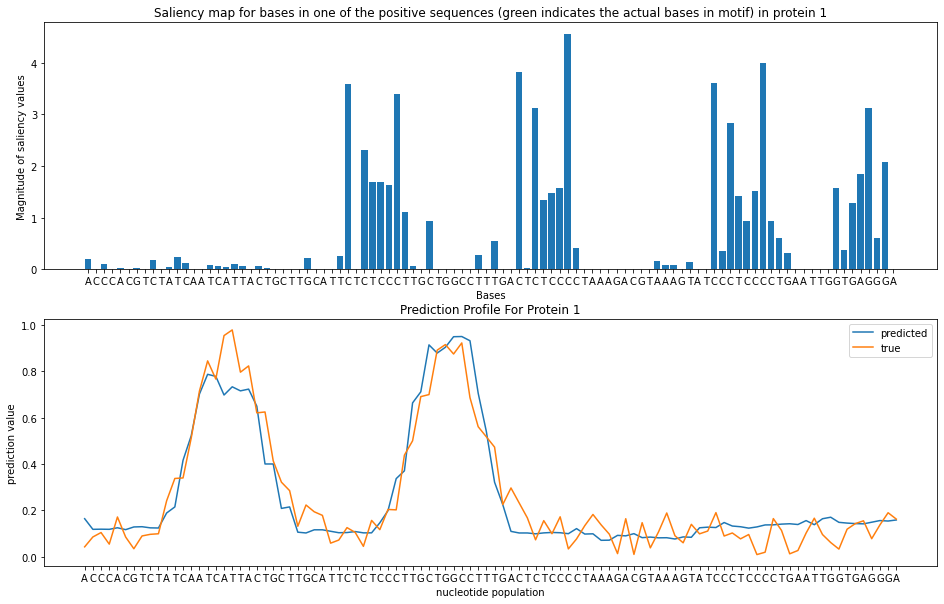

In [127]:
#plot 1:
plt.figure(figsize=(16,10))
plt.subplot(2, 1, 1)
sequence_index = 1234  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index],0)
plt.bar(np.arange(len(sal)), sal)
 # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]))
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif) in protein 1')

#plot 2:
plt.subplot(2, 1, 2)
plt.plot(preds[sequence_index,:,0])
plt.plot(test_labels[sequence_index,:,0])
plt.title('Prediction Profile For Protein 1')
plt.xticks(np.arange(max(len(preds[sequence_index,:,1]),len(test_labels[sequence_index,:,1]))), list(sequences[sequence_index]))
plt.ylabel('prediction value')
plt.xlabel('nucleotide population')
plt.legend(['predicted', 'true'])

plt.show()

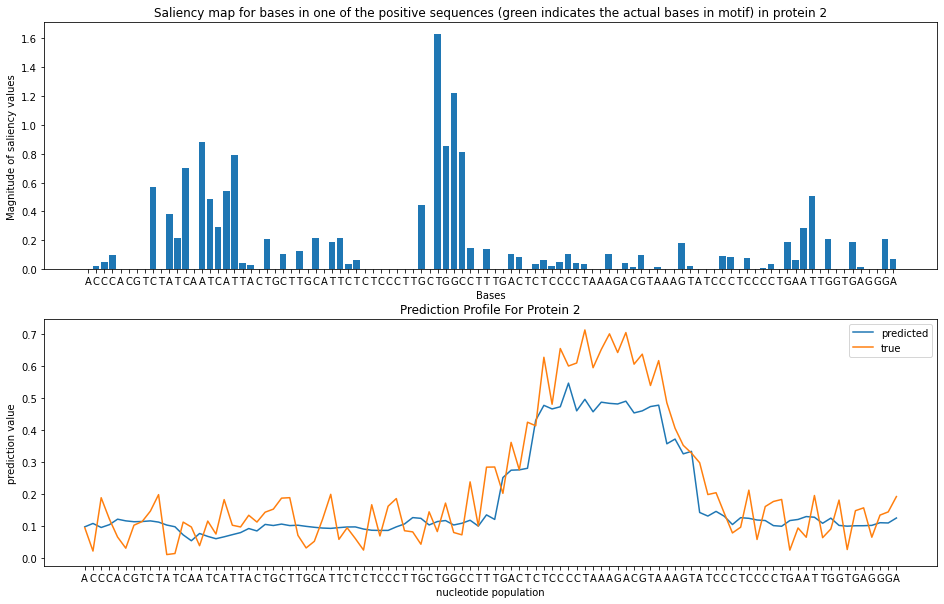

In [128]:
#plot 1:
plt.figure(figsize=(16,10))
plt.subplot(2, 1, 1)
sequence_index = 1234  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index],1)
plt.bar(np.arange(len(sal)), sal)
 # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]))
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif) in protein 2')

#plot 2:
plt.subplot(2, 1, 2)
plt.plot(preds[sequence_index,:,1])
plt.plot(test_labels[sequence_index,:,1])
plt.title('Prediction Profile For Protein 2')
plt.xticks(np.arange(max(len(preds[sequence_index,:,1]),len(test_labels[sequence_index,:,1]))), list(sequences[sequence_index]))
plt.ylabel('prediction value')
plt.xlabel('nucleotide population')
plt.legend(['predicted', 'true'])

plt.show()

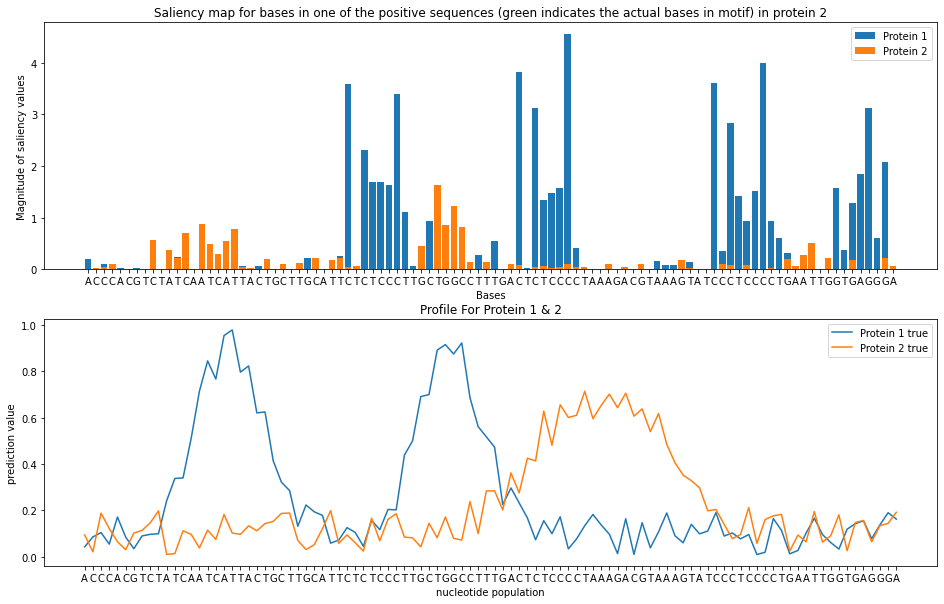

In [129]:
#plot 1:
plt.figure(figsize=(16,10))
plt.subplot(2, 1, 1)
sequence_index = 1234  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal1 = compute_salient_bases(model, input_features[sequence_index],0)
sal2 = compute_salient_bases(model, input_features[sequence_index],1)
plt.bar(np.arange(len(sal1)), sal1, label='Protein 1')
plt.bar(np.arange(len(sal2)), sal2, label='Protein 2')
  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(max(len(sal1),len(sal2))), list(sequences[sequence_index]))
plt.legend()
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif) in protein 2')

#plot 2:

plt.subplot(2, 1, 2)
#plt.plot(test1[50,:,0],label='Protein 1 predicted')
plt.plot(test_labels[sequence_index,:,0],label='Protein 1 true')
#plt.plot(test1[50,:,1],label='Protein 2 predicted')
plt.plot(test_labels[sequence_index,:,1],label='Protein 2 true')
plt.title('Profile For Protein 1 & 2')
plt.xticks(np.arange(max(len(preds[sequence_index,:,0]),len(preds[sequence_index,:,1]))), list(sequences[sequence_index]))
plt.ylabel('prediction value')
plt.xlabel('nucleotide population')
plt.legend()

plt.show()

By looking at each ChIP-protein independently: 

- Motifs for ChIP-protein 1: CTCTCCC, CCCTCCCC, GTGAGGGA
- Motifs for ChIP-protein 2: ATCAT, TGGCC
- For all motifs in each ChIP-protein profile, the activation of motifs inhibit the protein profile.

By looking at the interactions between these two ChIP-proteins: 

- Motifs ATCAT, TGGCC from protein 2 boost the profile of protein 1
- Motif CTCTCCC shown the second times boosts the profile of protein 2



#Part 2: More data from another mysterious cell type

Your collaborators send you an update: they performed ChIP-seq for the same two factors in a yet another mysterious cell type and are getting puzzling results. They send you a second file. Seems like they are pretty good collaborators!

In [130]:
DATA_URL2 = 'https://raw.githubusercontent.com/Fudenberg-Research-Group/2022_seq-to-profile/main/dataset2.h5'


In [131]:
download_h5(DATA_URL2, filename = 'dataset1.h5')
### reading in the h5 data 
with  h5py.File('dataset1.h5', 'r') as h:
    sequences = h['seqs'].asstr()[()]
    targets = h['targets'][()]

Text(0.5, 0, 'position, bp')

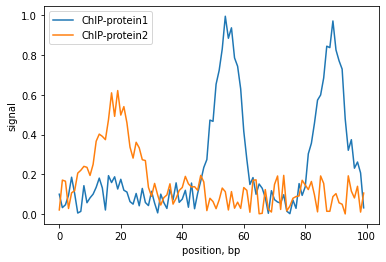

In [132]:
## To take a quick look at one of their profiles
plt.plot( targets[0,:,0], label='ChIP-protein1');

plt.plot( targets[0,:,1], label='ChIP-protein2');
plt.legend()
plt.ylabel("signal")
plt.xlabel("position, bp")

In [133]:
# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)



Example sequence
-----------------------
DNA Sequence #1:
 CGATGTGTCC ... GGGAGTGGGT
One hot encoding of Sequence #1:
 [[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


## 2.0 Does your model trained on the original data predict this data well or poorly? 

In [134]:
preds=model.predict(input_features)

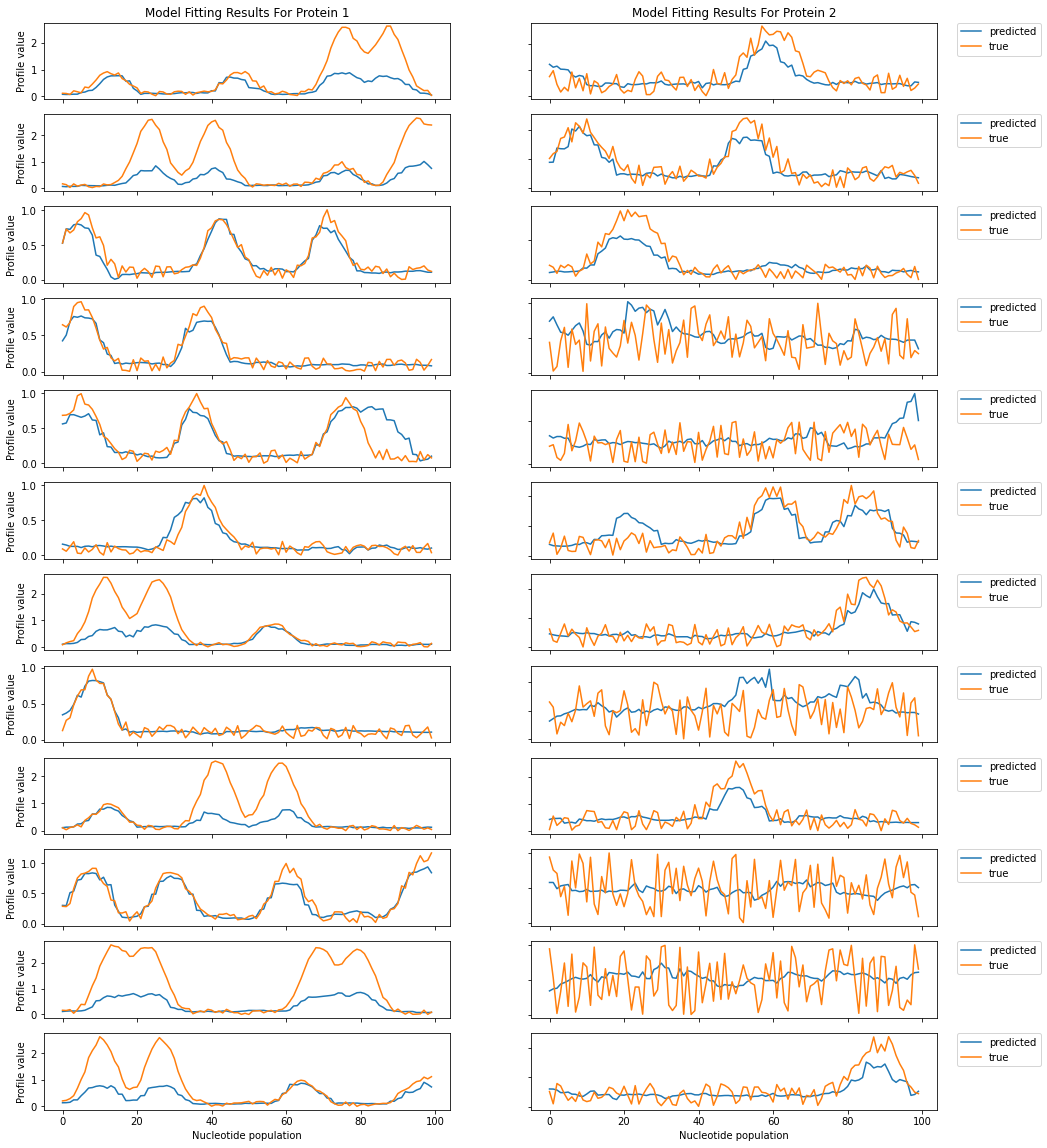

In [135]:
random.seed(123)
plot_fitting_result(random.sample(range(0, 1249), 12), preds, targets)

In [136]:
model.evaluate(input_features, targets)

[0.16209707260131836, 0.740396, 0.16209708, 0.8046603]

The previous model performs well on the new data with accuracy 74.04%, MSE 0.1621, and pearson correlation coefficient 0.804.

## 2.1 Does a model re-trained on this new dataset reach the same level of predictive ability?

In [137]:
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, targets, test_size=0.25, random_state=42)

random.seed(123)
callback = EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_features, train_labels, epochs=100, verbose=0, validation_split=0.25, callbacks=[callback])

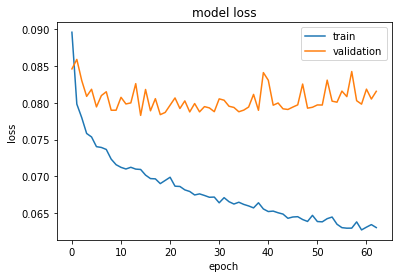

In [138]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [139]:
preds=model.predict(test_features)

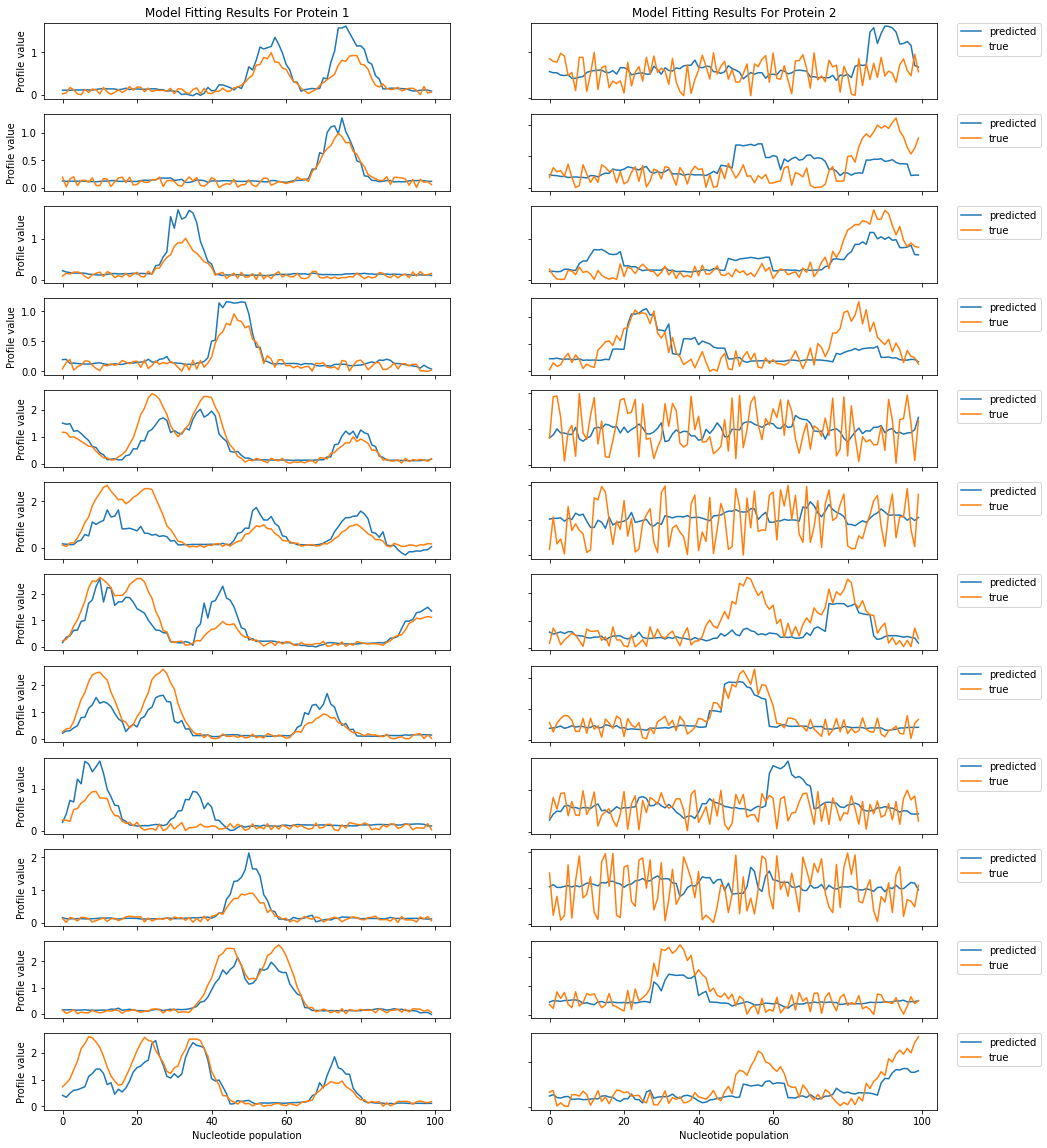

In [140]:
random.seed(123)
plot_fitting_result(random.sample(range(0, 1249), 12), preds, test_labels)

In [141]:
model.evaluate(test_features, test_labels)

[0.08098191801309586, 0.734184, 0.080981925, 0.84231746]

Yes, the model re-trained on this new dataset reach the same level of predictive ability, which is around 73.42%, MSE 0.081, and pearson correlation coefficient 0.8423.

## 2.2 Can you determine different rule(s) for the influence on the profiles in this new cell type?

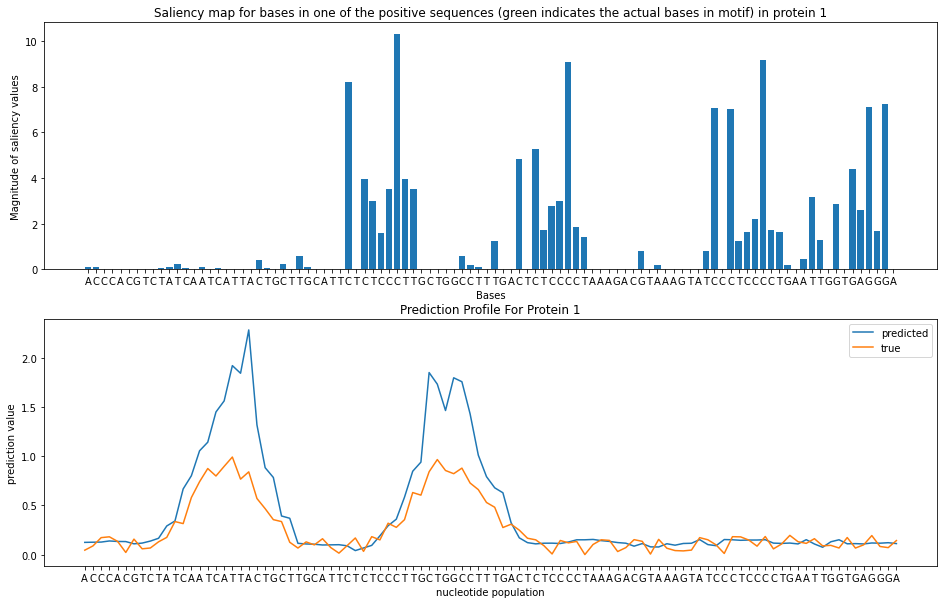

In [142]:
#plot 1:
plt.figure(figsize=(16,10))
plt.subplot(2, 1, 1)
sequence_index = 1234  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index],0)
plt.bar(np.arange(len(sal)), sal)
 # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]))
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif) in protein 1')

#plot 2:
plt.subplot(2, 1, 2)
plt.plot(preds[sequence_index,:,0])
plt.plot(test_labels[sequence_index,:,0])
plt.title('Prediction Profile For Protein 1')
plt.xticks(np.arange(max(len(preds[sequence_index,:,1]),len(test_labels[sequence_index,:,1]))), list(sequences[sequence_index]))
plt.ylabel('prediction value')
plt.xlabel('nucleotide population')
plt.legend(['predicted', 'true'])

plt.show()

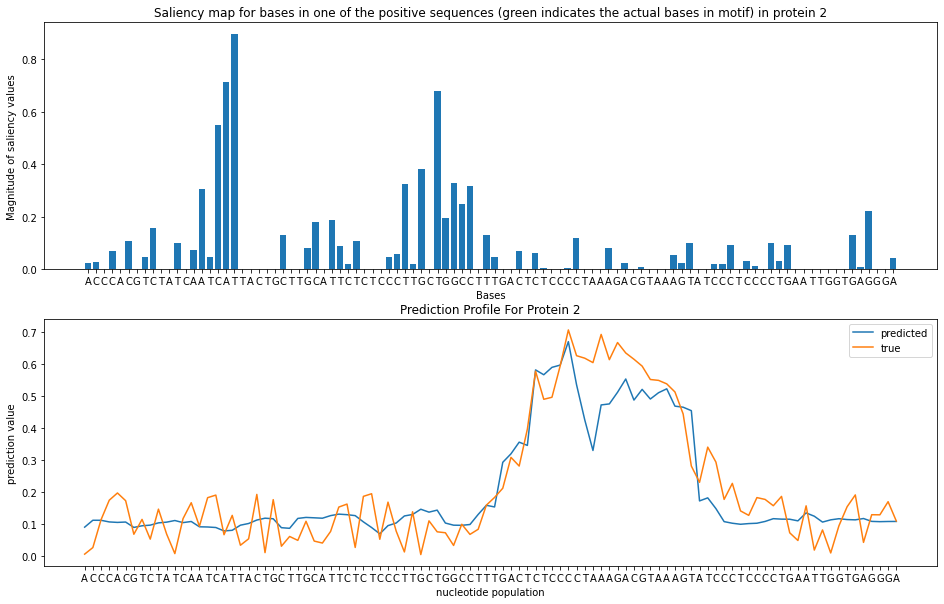

In [143]:
#plot 1:
plt.figure(figsize=(16,10))
plt.subplot(2, 1, 1)
sequence_index = 1234  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index],1)
plt.bar(np.arange(len(sal)), sal)
 # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]))
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif) in protein 2')

#plot 2:
plt.subplot(2, 1, 2)
plt.plot(preds[sequence_index,:,1])
plt.plot(test_labels[sequence_index,:,1])
plt.title('Prediction Profile For Protein 2')
plt.xticks(np.arange(max(len(preds[sequence_index,:,1]),len(test_labels[sequence_index,:,1]))), list(sequences[sequence_index]))
plt.ylabel('prediction value')
plt.xlabel('nucleotide population')
plt.legend(['predicted', 'true'])

plt.show()

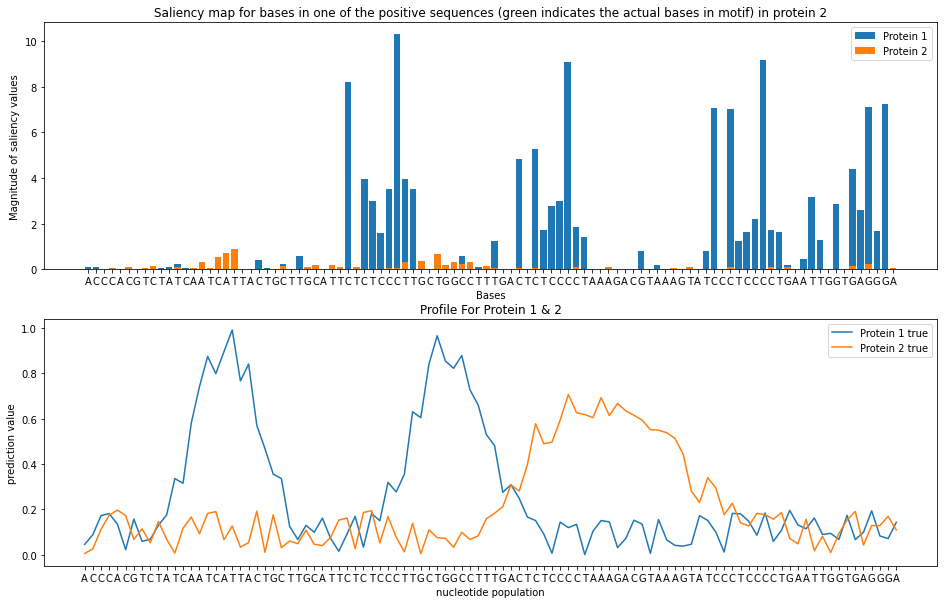

In [144]:
#plot 1:
plt.figure(figsize=(16,10))
plt.subplot(2, 1, 1)
sequence_index = 1234  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal1 = compute_salient_bases(model, input_features[sequence_index],0)
sal2 = compute_salient_bases(model, input_features[sequence_index],1)
plt.bar(np.arange(len(sal1)), sal1, label='Protein 1')
plt.bar(np.arange(len(sal2)), sal2, label='Protein 2')
  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(max(len(sal1),len(sal2))), list(sequences[sequence_index]))
plt.legend()
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif) in protein 2')

#plot 2:

plt.subplot(2, 1, 2)
#plt.plot(test1[50,:,0],label='Protein 1 predicted')
plt.plot(test_labels[sequence_index,:,0],label='Protein 1 true')
#plt.plot(test1[50,:,1],label='Protein 2 predicted')
plt.plot(test_labels[sequence_index,:,1],label='Protein 2 true')
plt.title('Profile For Protein 1 & 2')
plt.xticks(np.arange(max(len(preds[sequence_index,:,0]),len(preds[sequence_index,:,1]))), list(sequences[sequence_index]))
plt.ylabel('prediction value')
plt.xlabel('nucleotide population')
plt.legend()

plt.show()

By looking at each ChIP-protein independently: 

- Motifs for ChIP-protein 1: CTCTCCCT, CCCTCCCCT, GTGAGGGA
- Motifs for ChIP-protein 2: ATCAT, TGGCC
- For all motifs in each ChIP-protein profile, the activation of motifs inhibit the protein profile.

By looking at the interactions between these two ChIP-proteins: 

- Motifs ATCAT, TGGCC from protein 2 boost the profile of protein 1
- Motif CTCTCCC shown the second times boosts the profile of protein 2

